<a href="https://colab.research.google.com/github/sw-programmer/Coursework1/blob/sangwoo/CW1_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Coursework 1**

1.   ### **Computationally Efficient Eigenfaces**
2.   ### **Incremental PCA**
3.   ### **PCA-LDA for Face Recognition**
4.   ### **K-means codebook**
5.   ### **RF classifier**


**by 20190223	Soohyun Ryu,	20190247	Sangwoo Park**






**1. Setting!**

In [2]:
import os
import time
# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import datetime
# import math
# import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#mat_file = io.loadmat("/content/drive/MyDrive/CV_ML/CW1/face.mat")
mat_file = io.loadmat("./face.mat")
mat_X = mat_file['X']
mat_Y = mat_file['l'][0]

print(mat_file.keys()) 
print(mat_X.shape)                         # 총 52명. 각 10장의 사진. 

dict_keys(['__header__', '__version__', '__globals__', 'X', 'l'])
(2576, 520)


In [3]:
df = pd.DataFrame(data=mat_X).transpose()
df['label'] = mat_Y                         # row -> data, col -> feature
print(df)

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values # column 'Target'

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=35) #sklearn lib
# test/train ratio = 0.2
# random_state -> before dividing, seed for shuffling
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

plt.imshow(np.reshape(X_train[0,:],(46,56)).T, cmap = 'gist_gray') # 그냥...어떻게 생겼나 궁금해서...

NameError: name 'mat_X' is not defined

In [22]:
plt.imsave('practice.png', np.reshape(X_train[0,:],(46,56)).T, cmap='gist_gray')

## **1. Computationally Efficient Eignefaces**



In [32]:
# 평균 얼굴 계산 함수 
def AvgCompute(X): 
  Xbar = np.mean(X, axis=0)  
  matrix_A = X - Xbar 
  return matrix_A, Xbar

# 고유값, 고유벡터 계산 함수
def eig(S): 
  eig_vals, eig_vecs = np.linalg.eig(S) 
  sort_indices = np.argsort(eig_vals)[::-1] # 내림차순 정렬 
  return eig_vals[sort_indices], eig_vecs[:, sort_indices]

# Reconstruction에 쓰일 함수
def reconstruct(X, PC): 
  return (X @ PC) @ PC.T

# PCA 과정
def PCA(X, num_components, low_dim = False): # X == train set, num_components == 선택할 eigen vector 개수
  start = time.time()
  N, D = X.shape 
  matrix_A, X_bar = AvgCompute(X)
  if not low_dim:
    S = (matrix_A.T @ matrix_A) / N
  else:
    S = (matrix_A @ matrix_A.T) / N

  eig_vals, eig_vecs = eig(S)
  principal_vals, principal_components = np.real(eig_vals[:num_components]), np.real(eig_vecs[:,:num_components]) 
  
  if low_dim:
    principal_components = matrix_A.T @ principal_components

  reconst_X = reconstruct(matrix_A, principal_components) + X_bar 
  comp_time = time.time() - start
  
  return reconst_X, X_bar, principal_vals, principal_components, comp_time

(2576,)
(416, 2576)


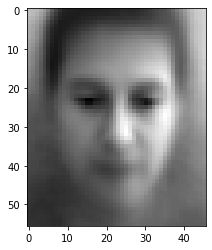

In [17]:
# mean image
A, X_bar = AvgCompute(X_train)
print(X_bar.shape)
print(A.shape)

plt.imshow(np.reshape(X_bar,(46,56)).T, cmap = 'gist_gray') # 평균 얼굴 출력

In [7]:
# 1. S=(1/N)AAT 방식
row, col = X_train.shape
S = (A.T @ A) / row
eig_vals_high, eig_vecs_high = eig(S) # High dimnesional
eig_vals_high = np.real(eig_vals_high)
eig_vecs_high = np.real(eig_vecs_high)

print(eig_vals_high.shape)
print(eig_vecs_high.shape)

(2576,)
(2576, 2576)


* Pros : 보다 정확
* Cons : Ineffieciency of Computation

In [14]:
# 2.  (1/N)ATA 방식
S = (A @ A.T) / row
eig_vals_low, eig_vecs_low = eig(S) # Low dimnesional
eig_vals_low = np.real(eig_vals_low)
eig_vecs_low = np.real(eig_vecs_low)
eig_vecs_low = A.T @ eig_vecs_low

print(eig_vals_low.shape)
print(eig_vecs_low.shape)

(416,)
(2576, 416)


* Pros : Effieciency of Computation
* Cons : 선택할 수 있는 EigenVector 수가 적다(?) -> Less accurate



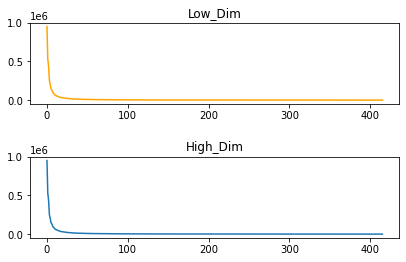

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.title('Low_Dim')
ax1.plot(range(0,416), eig_vals_low, color='orange')	
ax2 = fig.add_subplot(212)
plt.title('High_Dim')
ax2.plot(range(0,416), eig_vals_high[:416])	 # 두 eigenvalue 그래프가 동일함

fig.tight_layout(pad=2.0)

print()

In [ ]:
# number of PCA bases 바꾸면서 reconstruction error 측정
max_num = 200
start_num = 10
error_list = []
computation_time = []

os.makedirs("./PCA_org", exist_ok=True)
os.makedirs("./PCA_low_dim", exist_ok=True)

# Original PCA / Low-dim PCA
low_dim=False
# low_dim=True
if low_dim:
    root_path = "./PCA_low_dim"
else:
    root_path = "./PCA_org"

for i in range(start_num, max_num+1):
    reconst_X, X_bar, principal_vals, principal_components, comp_time = PCA(X_train, i, low_dim)
    recon_loss = np.linalg.norm((X_train - reconst_X), None)
    error_list.append(recon_loss)
    computation_time.append(comp_time)
    # To see the reconstructed images
    plt.imsave(f"{root_path}/{i}_recon.png", np.reshape(reconst_X[0,:],(46,56)).T, cmap = 'gist_gray')
    print(f"{i-start_num+1}/{max_num-start_num+1}")

if not low_dim:
    PCA_name = "Original PCA"
else:
    PCA_name = "Low-dim PCA"

x_axis = list(range(start_num, max_num+1))
fig_recon, ax_recon = plt.subplots(2,1)
ax_recon[0].plot(x_axis, error_list)
ax_recon[0].set_xlabel("number of PCA bases")
ax_recon[0].set_ylabel("reconstruction error")
ax_recon[0].set_title(f"Reconstruction error of {PCA_name}")

ax_recon[1].plot(x_axis, computation_time)
ax_recon[1].set_xlabel("number of PCA bases")
ax_recon[1].set_ylabel("computation time")
ax_recon[1].set_title(f"Computation time of {PCA_name}")

fig_recon.tight_layout(pad=2.0)

plt.show()

print(f"average computation time = {np.mean(computation_time)}")